In [1]:
%matplotlib inline


# Fitting an image and points

In this example, we will fit a cross onto the same cross, but rotated. We will take advantage of this knowledge and use a rotation deformation module. We will also add some noise on the initial center guess to show how to fit the geometrical descriptors. In addition to images, we add points at the extremity of each branch that will also get matched in order to illustrate multi deformables matching. This also helps the fitting process by adding more information to the model.




Import relevant modules.




In [2]:
import sys
sys.path.append("../")

import math

import torch
import matplotlib.pyplot as plt
import scipy.ndimage

import imodal

imodal.Utilities.set_compute_backend('torch')

Load image data and generate dots.




In [3]:
pwd

'/home/gris/algos/implicitmodules/script'

In [4]:
source_image = imodal.Utilities.load_greyscale_image("../data/images/heart_a.png", origin='lower')
target_image = imodal.Utilities.load_greyscale_image("../data/images/heart_b.png", origin='lower')

# Smoothing
sig_smooth = 0.
source_image = torch.tensor(scipy.ndimage.gaussian_filter(source_image, sig_smooth))
target_image = torch.tensor(scipy.ndimage.gaussian_filter(target_image, sig_smooth))

extent_length = 31.
extent = imodal.Utilities.AABB(0., extent_length, 0., extent_length)

Plot everything.




In [6]:
source_deformable = imodal.Models.DeformableImage(source_image, output='bitmap', extent='match', backward=False)
source_deformable2 = imodal.Models.DeformableImage(source_image, output='bitmap', extent='match', backward=True)
target_deformable = imodal.Models.DeformableImage(target_image, output='bitmap', extent='match', backward=False)


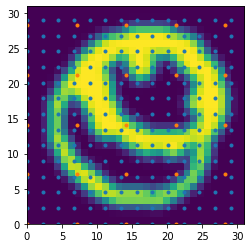

In [7]:

aabb = imodal.Utilities.AABB(0, source_image.shape[0]-1, 0, source_image.shape[1]-1)
small_scale_density = 0.2
large_scale_density = 0.02

small_scale_points = aabb.fill_uniform_density(small_scale_density)
large_scale_points = aabb.fill_uniform_density(large_scale_density)

small_scale_sigma = 1.5/small_scale_density
large_scale_sigma = 1.5/large_scale_density

small_scale_translations = imodal.DeformationModules.ImplicitModule0(2, small_scale_points.shape[0], small_scale_sigma, nu=0.1, gd=small_scale_points.clone().requires_grad_())
large_scale_translations = imodal.DeformationModules.ImplicitModule0(2, large_scale_points.shape[0], large_scale_sigma, nu=0.1, gd=large_scale_points.clone().requires_grad_())

###############################################################################
# Plot translations points
#

plt.imshow(source_image, origin='lower', extent=source_deformable.extent)
plt.plot(small_scale_points[:, 0].numpy(), small_scale_points[:, 1].numpy(), '.')
plt.plot(large_scale_points[:, 0].numpy(), large_scale_points[:, 1].numpy(), '.')
plt.show()



In [8]:

###############################################################################
# Model
#

#model = imodal.Models.RegistrationModel(source_deformable, [small_scale_translations, large_scale_translations], imodal.Attachment.EuclideanPointwiseDistanceAttachment(), lam=100.)
model = imodal.Models.RegistrationModel(source_deformable, [small_scale_translations, large_scale_translations], imodal.Attachment.L2NormAttachment(transform=None), lam=100.)


###############################################################################
# We fit the model.
#

shoot_solver = 'euler'
shoot_it = 10

costs = {}
fitter = imodal.Models.Fitter(model, optimizer='torch_lbfgs')
fitter.fit(target_deformable, 50, costs=costs, options={'shoot_solver': shoot_solver, 'shoot_it': shoot_it, 'line_search_fn': 'strong_wolfe'})




Starting optimization with method torch LBFGS, using solver euler with 10 iterations.
Initial cost={'deformation': 0.0, 'attach': 18073.7265625}
1e-10
Evaluated model with costs=18073.7265625
Evaluated model with costs=19043.958383113146
Evaluated model with costs=17804.98829947412
Evaluated model with costs=17759.2094360739
Evaluated model with costs=17633.763144254684
Evaluated model with costs=17366.206879258156
Evaluated model with costs=16275.07023191452
Evaluated model with costs=16144.60551738739
Evaluated model with costs=15328.527973175049
Evaluated model with costs=15050.307918548584
Evaluated model with costs=14189.911421775818
Evaluated model with costs=13205.769872665405
Evaluated model with costs=12585.918451309204
Evaluated model with costs=11847.630685806274


KeyboardInterrupt: 

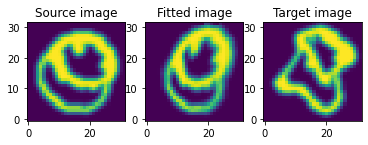

In [9]:


with torch.autograd.no_grad():
    deformed_image = model.compute_deformed(shoot_solver, shoot_it)[0][0]

fitted_center = model.init_manifold[1].gd.detach()

plt.subplot(1, 3, 1)
plt.title("Source image")
plt.imshow(source_image, origin='lower')

plt.subplot(1, 3, 2)
plt.title("Fitted image")
plt.imshow(deformed_image, origin='lower')

plt.subplot(1, 3, 3)
plt.title("Target image")
plt.imshow(target_image, origin='lower')

plt.show()



